In [117]:
import pandas as pd
import geopandas as gpd
import numpy as np
import tifffile as tiff
import zarr
import cv2
import gzip
from scipy.io import mmread
from shapely.geometry import Point, Polygon
from pathlib import Path
from pyarrow import parquet as pq
from shapely.affinity import scale
from rasterio.features import rasterize
from typing import List, Optional
from skimage.measure import regionprops_table

def coord_to_polygon(
    coords_path: Path
) -> Polygon:
    """
    Convert the selection coordinates downloaded from Xenium explorer to Polygon for 
    later subsetting of transcripts and the morphology image. 

    Parameters
    ----------
    coords_path : Path
        Path to the coordinates.csv file.

    Returns
    -------
    Polygon
        Coordinates converted to an object of class polygon.
    """

    polygon_transcripts_df = pd.read_csv(coords_path, skiprows=3, header=None, names=['x', 'y'])

    polygon_transcripts_df = polygon_transcripts_df.clip(lower=0)
    
    polygon = Polygon(zip(polygon_transcripts_df['x'].to_list(), polygon_transcripts_df['y'].to_list()))

    return polygon

def subset_transcripts(
    poly: Polygon,
    transcripts_path: Path,
    shift: bool = True
) -> pd.DataFrame:
    """
    Subset transcripts file based on intersection with polygon.

    Parameters
    ----------
    poly : Polygon
        Reference polygon computed based on preselected area in Xenium explorer.
    transcripts_path : Path
        Path to transcripts file (parquet, csv or tsv).
    shift : bool
        Whether to shift transcripts to origin or not. This function should be adapted
        at a later timepoint to allow parameter poly to be a list of polygons and in
        that case set shift to False.

    Returns
    -------
    pd.DataFrame 
        Cropped transcripts dataframe.
    """
    # consider using spatial indexing!
    compression = "gzip" if transcripts_path.suffixes[-1] == ".gz" else None

    if transcripts_path.suffix in [".tsv", ".tsv.gz"]:
        transcripts_df = pd.read_csv(transcripts_path, sep="\t", compression=compression)
    elif transcripts_path.suffix in [".csv", ".csv.gz"]:
        transcripts_df = pd.read_csv(transcripts_path, compression=compression)
    elif transcripts_path.suffix == ".parquet":
        transcripts_df = pq.read_table(transcripts_path).to_pandas()
    else:
        raise ValueError(f"Unsupported file format: {transcripts_path.suffix}")
    
    # subset before query 
    min_x, min_y, max_x, max_y = poly.bounds
    # rounding values to make sure that values an the border of the polygon are excluded, e.g. values > 899 including 899.9 will be excluded if border is at 900
    transcripts_in_bbox = transcripts_df[
    (np.floor(transcripts_df["x_location"]).astype(int) > int(np.ceil(min_x))) & 
    (np.ceil(transcripts_df["x_location"]).astype(int) < int(np.floor(max_x))) &
    (np.floor(transcripts_df["y_location"]).astype(int) > int(np.ceil(min_y))) & 
    (np.ceil(transcripts_df["y_location"]).astype(int) < int(np.floor(max_y)))
    ]

    # add geometry
    transcripts_in_bbox["geometry"] = transcripts_in_bbox.apply(
    lambda row: Point(row["x_location"], row["y_location"]), axis=1
    )

    # convert to GeoDataFrame
    transcripts_gdf_bbox = gpd.GeoDataFrame(transcripts_in_bbox, geometry="geometry")

    # crop to polygon shape
    transcripts_in_polygon = transcripts_gdf_bbox[transcripts_gdf_bbox["geometry"].within(poly)]

    # convert back to dataframe
    transcripts_in_polygon_df = transcripts_in_polygon.drop(columns="geometry")

    if shift:
        # shift to origin
        shift_x = min_x
        shift_y = min_y

        transcripts_in_polygon_df["x_location"] = transcripts_in_polygon_df["x_location"] - shift_x
        transcripts_in_polygon_df["y_location"] = transcripts_in_polygon_df["y_location"] - shift_y

    return transcripts_in_polygon_df

def get_nucleus_by_feature_df(
        transcripts_df: pd.DataFrame,
        mask: np.ndarray,
        prefixes: tuple[str, ...] = (
        "NegControlProbe_",
        "antisense_",
        "NegControlCodeword_",
        "BLANK_",
        "Blank-",
        "NegPrb",
        "DeprecatedCodeword_",
        "Intergenic_Region_",
        "UnassignedCodeword_"
        ),
        qv_th: int = 20
) -> pd.DataFrame:
    
    """
    Computes cell by feature matrix based on transcripts file and segmentation mask.

    Parameters
    ----------
    transcripts_df: pd.DataFrame
        A dataframe of transcripts (read from transcripts.parquet or .csv and either subset or not).
    mask: np.ndarray
        A segmentation mask (nuclear or cell).
    prefixes: tuple[str, ...]
        Prefixes of genes that are later excluded from the transcripts in methods like BIDCell or Segger.
    qv_th: int
        Threshold for quality control metric later used to exclude genes from transcripts in methods like BIDCell or Segger.

    Returns
    -------
    pd.DataFrame
        A dataframe of cells/nuclei by features (genes, cell centroids and size.)
    """
    
    transcripts_df["feature_name"] = transcripts_df["feature_name"].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
    transcripts_df = transcripts_df.loc[(~transcripts_df["feature_name"].str.startswith(prefixes)) & (transcripts_df["qv"] >= qv_th), :]

    x_coords = transcripts_df["x_location"].values
    y_coords = transcripts_df["y_location"].values

    cell_ids = mask[np.round(y_coords).astype(int), np.round(x_coords).astype(int)]
    transcripts_df["cell_id"] = cell_ids
    transcripts_df = transcripts_df[transcripts_df["cell_id"]>0]
    nucleus_by_feature = transcripts_df.pivot_table(index="cell_id", columns="feature_name", aggfunc="size", fill_value=0)

    props = regionprops_table(mask, properties=["label", "area", "centroid"])
    df_nucleus_props = pd.DataFrame(props)
    df_nucleus_props = df_nucleus_props.rename(columns={"label":"cell_id", "area": "cell_size", "centroid-0": "centroid_y", "centroid-1": "centroid_x"})
    
    nucleus_by_feature = nucleus_by_feature.reset_index()

    nucleus_feature_df = df_nucleus_props.merge(nucleus_by_feature, on="cell_id", how="left")
    nucleus_feature_df.fillna(0, inplace=True)
    return nucleus_feature_df

def subset_cell_boundaries(
    poly: Polygon,
    boundaries_path: Path,
    shift: bool = True
) -> pd.DataFrame:
    """
    Subset cell boundaries parquet file based on intersection with polygon - required for Segger.

    Parameters
    ----------
    poly : Polygon
        Reference polygon computed based on preselected area in Xenium explorer.
    boundaries_path : Path
        Path to cell_boundaries.parquet.
    shift : bool
        Whether to shift buondaries to origin or not. This function should be adapted
        at a later timepoint to allow parameter poly to be a list of polygons and in
        that case set shift to False.

    Returns
    -------
    pd.DataFrame 
        Subset boundaries dataframe.
    """

    boundaries_df = pq.read_table(boundaries_path).to_pandas()

    # Subset before query
    min_x, min_y, max_x, max_y = poly.bounds
    boundaries_in_bbox = boundaries_df[
    (np.floor(boundaries_df["vertex_x"]).astype(int) > int(np.ceil(min_x))) & 
    (np.ceil(boundaries_df["vertex_x"]).astype(int) < int(np.floor(max_x))) &
    (np.floor(boundaries_df["vertex_y"]).astype(int) > int(np.ceil(min_y))) & 
    (np.ceil(boundaries_df["vertex_y"]).astype(int) < int(np.floor(max_y)))
    ]

    # Create a GeoPandas DataFrame with geometry points
    geometry = [Point(x, y) for x, y in zip(boundaries_in_bbox['vertex_x'], boundaries_in_bbox['vertex_y'])]
    gdf = gpd.GeoDataFrame(boundaries_in_bbox, geometry=geometry)

    # Filter rows that are inside the polygon
    filtered_gdf = gdf[gdf.geometry.within(poly)]

    if shift:
        min_x, min_y, max_x, max_y = poly.bounds
        # shift to origin
        shift_x = min_x
        shift_y = min_y
        filtered_gdf['vertex_x'] = filtered_gdf.geometry.x - shift_x
        filtered_gdf['vertex_y'] = filtered_gdf.geometry.y - shift_y

    # Drop the geometry column
    filtered_gdf = filtered_gdf.drop(columns='geometry')
    
    # Close open rings after cropping
    vertex_data = [] 
    for cell_id, group in filtered_gdf.groupby('cell_id'):
        coords = group[['vertex_x', 'vertex_y']].values
        #if len(coords) >= 4:  # closed rings/polygons
        # if not (coords[0] == coords[-1]).all():  # Close the ring if needed
        #     coords = np.vstack([coords, coords[0]])
        # Append each vertex with metadata
        for coord in coords:
            vertex_data.append({
                'cell_id': cell_id,
                # 'label_id': group['label_id'].iloc[0], 
                'vertex_x': coord[0],
                'vertex_y': coord[1]
            })
        # else:
        #     print(f"Skipping incomplete boundary for cell_id: {cell_id}")

    # Create a DataFrame with vertex_x and vertex_y
    vertex_df = pd.DataFrame(vertex_data)

    return vertex_df

# def subset_xenium_for_cellspa(
#     poly: Polygon,
#     xenium_dir: Path,
#     feat_subset: Optional[List[str]] = None,
#     shift: bool = True
# ) -> List[pd.DataFrame]:
#     """
#     Subset Xenium outputs for use with CellSPA using a polygon.

#     Parameters
#     ----------
#     poly : Polygon
#         Reference polygon drawn in Xenium Explorer.
#     xenium_dir : Path
#         Directory to Xenium output files.
#     feat_subset : Optional[List[str]]
#         List of gene/feature IDs to keep.
#     shift : bool
#         Whether to shift cell coordinates to origin.

#     Returns
#     -------
#     List[pd.DataFrame]
#         Subsets: [cell_metadata, features, barcodes, expression_matrix]
#     """

#     # Load uncompressed cells.tsv
#     cells_path = xenium_dir / 'cells.csv.gz'
#     cells_df = pd.read_csv(cells_path, compression='gzip')
#     cells_df["cell_id"] = cells_df.index + 1  # +1 for CellSPA indexing

#     # Subset based on polygon bounding box
#     min_x, min_y, max_x, max_y = poly.bounds
#     prefilter = cells_df[
#         (np.floor(cells_df["x_centroid"]).astype(int) > int(np.ceil(min_x))) & 
#         (np.ceil(cells_df["x_centroid"]).astype(int) < int(np.floor(max_x))) &
#         (np.floor(cells_df["y_centroid"]).astype(int) > int(np.ceil(min_y))) & 
#         (np.ceil(cells_df["y_centroid"]).astype(int) < int(np.floor(max_y)))
#     ].copy()

#     # Add geometry and subset with polygon
#     prefilter["geometry"] = prefilter.apply(lambda row: Point(row["x_centroid"], row["y_centroid"]), axis=1)
#     cell_subset = prefilter[prefilter["geometry"].apply(poly.contains)].copy()
#     cell_subset.drop(columns=["geometry"], inplace=True)

#     if shift:
#         cell_subset["x_centroid"] -= min_x
#         cell_subset["y_centroid"] -= min_y

#     # Load features.tsv and optionally subset
#     feature_subset = pd.read_csv(xenium_dir / 'cell_feature_matrix/features.tsv', sep='\t', header=None)
#     if feat_subset is not None:
#         feature_subset = feature_subset[feature_subset.iloc[:, 0].isin(feat_subset)]

#     # Load barcodes.tsv and match to cell IDs
#     barcodes = pd.read_csv(xenium_dir / 'cell_feature_matrix/barcodes.tsv', sep='\t', header=None)
#     barcodes.iloc[:, 0] = barcodes.index + 1  # +1 for CellSPA indexing
#     barcode_subset = barcodes[barcodes.iloc[:, 0].isin(cell_subset["cell_id"])]

#     # Load matrix.mtx (still can be gzipped)
#     matrix_path = xenium_dir / 'cell_feature_matrix/matrix.mtx'
#     sparse_matrix = mmread(matrix_path).tocsr()

#     # Subset matrix by barcodes (columns)
#     barcodes_set = set(barcode_subset.iloc[:, 0])
#     col_indices = [i for i, barcode in enumerate(barcodes.iloc[:, 0]) if barcode in barcodes_set]
#     matrix_subset = sparse_matrix[:, col_indices]

#     # Subset matrix by features (rows)
#     if feat_subset is not None:
#         # Get matching feature indices
#         feature_indices = [i for i, feat_id in enumerate(feature_subset.iloc[:, 0])]
#         matrix_subset = matrix_subset[feature_indices, :]

#     matrix_subset_df = pd.DataFrame(matrix_subset.toarray())

#     return [cell_subset, feature_subset, barcode_subset, matrix_subset_df]

def polygon_to_image(
    poly: Polygon,
    shape: tuple,
    pixel_to_um: float = 0.2125      
) -> np.ndarray:
    """
    Convert polygon to a binary mask image, that can be used to crop Xenium images.
    
    Parameters
    ----------
    poly : Polygon
        Reference polygon computed based on preselected area in Xenium explorer.
    shape : tuple
        Output shape for binary mask image.
    
    Returns
    -------
    np.ndarray
        Binary mask image.
    """

    # map polygon coordinates from um to pixel space
    poly_px = scale(poly, xfact=1/pixel_to_um, yfact=1/pixel_to_um, origin=(0, 0))

    # create a binary mask
    binary_mask = rasterize(
        [(poly_px, 1)],  
        out_shape=(shape),  
        fill=0,  
        dtype=np.uint8  
    )

    return binary_mask

def crop_to_binarymask(
        img: np.ndarray,
        binary: np.ndarray,
        crop: bool = True
) -> np.ndarray:
    """
    Crop an image to the bounding box of a binary image.

    Parameters
    ----------
    img : np.ndarray
        Image to crop.
    binary : np.ndarray
        Binary image used as reference.
    crop: bool
        Whether to crop the image after multiplication with mask. That is preferred for BIDCell
        to reduce runtime.

    Returns
    -------
    np.ndarray
        Cropped image.
    """
        
    # Find the bounding box of the binary mask
    rows = np.any(binary, axis=1)
    cols = np.any(binary, axis=0)

    row_min, row_max = np.where(rows)[0][[0, -1]]
    col_min, col_max = np.where(cols)[0][[0, -1]]

    # Crop the image and binary mask to the bounding box
    cropped_img = img[row_min:row_max+1, col_min:col_max+1]
    cropped_binary = binary[row_min:row_max+1, col_min:col_max+1]

    # Apply the mask to the cropped image
    subset_img = np.where(cropped_binary, cropped_img, 0)

    return subset_img


def subset_image(
    poly: Polygon,
    image: np.ndarray,
    crop: bool = True,
    pixel_to_um: float = 0.2125      
) -> List[np.ndarray]:
    """
    Subset an image based on intersection with binary mask. This function can be also used to
    crop IF images of channels other than DAPI (e.g. Boundary, Interior-RNA, Interior-Protein)

    Parameters
    ----------
    poly : Polygon
        Reference polygon computed based on preselected area in Xenium explorer.
    image: 
        Any 2-dimensional numpy array.
    crop : bool
        Whether to crop image after setting pixels outside polygon to zero. 
        Crop is preferred for BIDCell to reduce memory requirements.
    pixel_to_um : float
        Pixel to µm conversion factor. 

    Returns
    -------
    list of np.ndarray 
        First array represents subset image in pixels.
        Second array represents subset image in µm. 
    """
    # convert polygon to binary mask
    mask = polygon_to_image(poly, image.shape)

    # crop image based on binary mask
    cropped_img_px = crop_to_binarymask(image, mask, crop)

    # convert cropped image to µm scale. 
    if cropped_img_px.dtype == "uint32": 
        # converting to float32 as cv2.resize does not support uint32.
        tmp = cropped_img_px.astype("float32")
        cropped_img_um = cv2.resize(tmp, (int(round(tmp.shape[1] * pixel_to_um)), int(round(tmp.shape[0] * pixel_to_um))), interpolation=cv2.INTER_NEAREST).astype("uint32")
    else:
        cropped_img_um = cv2.resize(cropped_img_px, (int(round(cropped_img_px.shape[1] * pixel_to_um)), int(round(cropped_img_px.shape[0] * pixel_to_um))))
    
    return [cropped_img_px, cropped_img_um]

def read_morph_image(
    path_to_tiff: Path
) -> np.ndarray:
    
    """
    Function to read morphology images from Xenium ome tiff files.

    Parameters
    ----------
    path_to_tiff : Path
        Path to 2-dim ome tiff image (either morphology_focus_000[1-3].ome.tiff or morphology_mip.ome.tiff).

    Returns
    -------
    np.ndarray
        Numpy array comprised of the image.
    """

    image = tiff.imread(path_to_tiff, is_ome=False, level=0) #level defines resolution (0 = highest res)

    return image

def read_xenium_masks(
    path_to_zarr: Path
) -> List[np.ndarray]:

    """
    Read xenium segmentation masks from cells.zarr.zip file. 

    Parameters
    ----------
    path_to_zarr : Path
        Path to cells.zarr.zip file.

    Returns
    -------
    list of np.ndarray 
        The first array represents the nuclear segmentation mask.
        The second array represents the cell segmentation mask. 
    """

    store = zarr.ZipStore(path_to_zarr, mode="r")
    root = zarr.group(store=store)

    nuc_mask = np.asarray(root["masks"][0])
    cell_mask = np.asarray(root["masks"][1])

    #nuc_mask = nuc_mask.astype(np.uint8) #be careful here, check values after
    #cell_mask = cell_mask.astype(np.uint8)

    return [nuc_mask, cell_mask]

def plot_validation(
        df: pd.DataFrame, 
        x_column: str,
        y_column: str,
        ref_shape: tuple
        ) -> np.ndarray:
    
    """
    Plot validation image for dataframe containing subset transcripts 
    or subset cell boundaries for visulization in napari.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing table data.
    x_column: str
        Name of column in dataframe containing x coordinates.
    y_column: str
        Name of column in dataframe containing y coordinates.
    ref_shape: tuple
        Reference shape - shape of the other subset images (nuclear and cell mask, morph. image etc.)

    Returns
    -------
    np.ndarray
        Numpy array (uint8) set to 255 at dataframe coordinates.
    """

    validation_img = np.zeros(ref_shape, dtype=np.uint8)

    x = np.round(df[x_column]).astype(int)
    y = np.round(df[y_column]).astype(int)

    np.add.at(validation_img, (y, x), 1)

    return validation_img

In [118]:
import spatialdata_io
from pathlib import Path

In [119]:
subset_dir = Path('/g/huber/users/meyerben/notebooks/spatial_transcriptomics/testing_notebooks/xenium_subset')

subset_dir = Path(subset_dir)
polygon = coord_to_polygon(subset_dir / "selection.csv")

In [120]:
import tifffile as tiff

xenium_dir = Path('/g/huber/projects/CODEX/segtraq/data/Replicate1')

masks = read_xenium_masks(xenium_dir / "cells.zarr.zip")
    
nuc_mask_subset = subset_image(polygon, masks[0])
cell_mask_subset = subset_image(polygon, masks[1])

tiff.imwrite(subset_dir / "nuc_mask_px.tif", nuc_mask_subset[0])
tiff.imwrite(subset_dir / "nuc_mask_um.tif", nuc_mask_subset[1])
tiff.imwrite(subset_dir / "cell_mask_px.tif", cell_mask_subset[0])
tiff.imwrite(subset_dir / "cell_mask_um.tif", cell_mask_subset[1])

In [121]:
len(np.unique(nuc_mask_subset[1]))

133

In [122]:
len(np.unique(cell_mask_subset[1]))

158

In [123]:
cell_id_list = np.unique(cell_mask_subset[1]).tolist()

In [124]:
def subset_xenium_for_cellspa(
    poly: Polygon,
    xenium_dir: Path,
    cell_ids: List,
    feat_subset: Optional[List[str]] = None,
    shift: bool = True,

) -> List[pd.DataFrame]:
    """
    Subset Xenium outputs for use with CellSPA using a polygon.

    Parameters
    ----------
    poly : Polygon
        Reference polygon drawn in Xenium Explorer.
    xenium_dir : Path
        Directory to Xenium output files.
    cell_ids : list
        List of cell_ids to keep.
    feat_subset : Optional[List[str]]
        List of gene/feature IDs to keep.
    shift : bool
        Whether to shift cell coordinates to origin.

    Returns
    -------
    List[pd.DataFrame]
        Subsets: [cell_metadata, features, barcodes, expression_matrix]
    """

    # Subset based on polygon bounding box
    min_x, min_y, max_x, max_y = poly.bounds

    # Load uncompressed cells.tsv
    cells_path = xenium_dir / 'cells.csv.gz'
    cells_df = pd.read_csv(cells_path, compression='gzip')
    cells_df["cell_id"] = cells_df.index + 1  # +1 for CellSPA indexing

    cell_subset = cells_df[cells_df["cell_id"].isin(cell_id_list)]

    if shift:
        cell_subset["x_centroid"] -= min_x
        cell_subset["y_centroid"] -= min_y

    # Load features.tsv and optionally subset
    feature_subset = pd.read_csv(xenium_dir / 'cell_feature_matrix/features.tsv', sep='\t', header=None)
    if feat_subset is not None:
        feature_subset = feature_subset[feature_subset.iloc[:, 0].isin(feat_subset)]

    # Load barcodes.tsv and match to cell IDs
    barcodes = pd.read_csv(xenium_dir / 'cell_feature_matrix/barcodes.tsv', sep='\t', header=None)
    barcodes.iloc[:, 0] = barcodes.index + 1  # +1 for CellSPA indexing
    barcode_subset = barcodes[barcodes.iloc[:, 0].isin(cell_subset["cell_id"])]

    # Load matrix.mtx (still can be gzipped)
    matrix_path = xenium_dir / 'cell_feature_matrix/matrix.mtx'
    sparse_matrix = mmread(matrix_path).tocsr()

    # Subset matrix by barcodes (columns)
    barcodes_set = set(barcode_subset.iloc[:, 0])
    col_indices = [i for i, barcode in enumerate(barcodes.iloc[:, 0]) if barcode in barcodes_set]
    matrix_subset = sparse_matrix[:, col_indices]

    # Subset matrix by features (rows)
    if feat_subset is not None:
        # Get matching feature indices
        feature_indices = [i for i, feat_id in enumerate(feature_subset.iloc[:, 0])]
        matrix_subset = matrix_subset[feature_indices, :]

    matrix_subset_df = pd.DataFrame(matrix_subset.toarray())

    return [cell_subset, feature_subset, barcode_subset, matrix_subset_df]

In [125]:
import gzip
import scipy

xenium_subset_cellspa = subset_xenium_for_cellspa(polygon, xenium_dir, cell_ids = cell_id_list)

xenium_subset_cellspa[0].to_csv(subset_dir / "cells.csv", index=False)

if not (subset_dir / "cell_feature_matrix").exists():
    (subset_dir / "cell_feature_matrix").mkdir()

xenium_subset_cellspa[1].to_csv(subset_dir / "cell_feature_matrix/features.tsv", sep = "\t", header= None, index=False)
xenium_subset_cellspa[2].to_csv(subset_dir / "cell_feature_matrix/barcodes.tsv", sep = "\t", header= None, index=False)

with gzip.open(subset_dir / "cell_feature_matrix/matrix.mtx.gz", "wb") as f:
    scipy.io.mmwrite(f, scipy.sparse.csr_matrix(xenium_subset_cellspa[3].values))

/tmp/ipykernel_1575891/1422032990.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset["x_centroid"] -= min_x
/tmp/ipykernel_1575891/1422032990.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset["y_centroid"] -= min_y


In [126]:
xenium_subset_cellspa[0]['cell_id'].nunique()

157

In [127]:
# DAPI
dapi = read_morph_image(xenium_dir / "morphology_focus.ome.tif")
dapi_subset = subset_image(polygon, dapi)
tiff.imwrite(subset_dir / "dapi_px.tif", dapi_subset[0])
tiff.imwrite(subset_dir / "dapi_um.tif", dapi_subset[1])

In [128]:
from pyarrow import Table, parquet as pq

transcript_subset = subset_transcripts(polygon, xenium_dir / "transcripts.parquet")

# Select file format for saving the subset transcripts file
tx_file_format = 'csv'

if tx_file_format == "parquet":
    table = Table.from_pandas(transcript_subset)
    pq.write_table(table, subset_dir / "transcripts.parquet")
elif tx_file_format == "csv":
    transcript_subset.to_csv(subset_dir / "transcripts.csv", index=False)
elif tx_file_format == "csv.gz":
    transcript_subset.to_csv(subset_dir / "transcripts.csv.gz", index=False, compression="gzip")
else:
    msg = f"Arg 'tx_file_format' should be 'parquet', 'csv', or 'csv.gz', but got {tx_file_format}."
    raise ValueError(msg)

/tmp/ipykernel_1575891/3087524907.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_in_bbox["geometry"] = transcripts_in_bbox.apply(


In [129]:
transcript_subset['cell_id'].nunique()

149

In [130]:
nuc_by_feat = get_nucleus_by_feature_df(transcript_subset, nuc_mask_subset[1])

cell_mat_dir = subset_dir / "cell_gene_matrices/nucleus"
if not cell_mat_dir.exists():
    cell_mat_dir.mkdir(parents=True, exist_ok=True)
    
nuc_by_feat.to_csv(cell_mat_dir / "cell_outputs_1.csv", index=False)

/tmp/ipykernel_1575891/3087524907.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df["cell_id"] = cell_ids


In [131]:
cell_boundaries_subset = subset_cell_boundaries(polygon, xenium_dir / "cell_boundaries.parquet")
table = Table.from_pandas(cell_boundaries_subset)
pq.write_table(table, subset_dir / "cell_boundaries.parquet")

cb_valid_img = plot_validation(cell_boundaries_subset, "vertex_x", "vertex_y", dapi_subset[1].shape)
tiff.imwrite(subset_dir / "cell_boundaries_um.tif", cb_valid_img)

nucleus_boundaries_subset = subset_cell_boundaries(polygon, xenium_dir / "nucleus_boundaries.parquet")
table = Table.from_pandas(nucleus_boundaries_subset)
pq.write_table(table, subset_dir / "nucleus_boundaries.parquet")

cb_valid_img = plot_validation(nucleus_boundaries_subset, "vertex_x", "vertex_y", dapi_subset[1].shape)
tiff.imwrite(subset_dir / "nucleus_boundaries_um.tif", cb_valid_img)

In [132]:
cell_boundaries_subset['cell_id'].nunique()

153

# Conversion to spatialdata

In [133]:
def read_xenium(
        path_to_data: Path
        ) -> tuple[pd.DataFrame, np.ndarray]:
    '''
    Read singl-cell data and mask from data segmented via 10x Xenium.

    Parameters:
    path_to_data (Path): Path to the directory containing the segmented data.
    
    Returns:
    tuple[pd.DataFrame, np.ndarray]: A tuple containing the single-cell counts DataFrame and the cell mask array.
    '''

    print('Reading Xenium data...')

    cell_mask = tiff.imread(f'{path_to_data}/cell_mask_um.tif')

    meta_df = pd.read_csv(f'{path_to_data}/cells.csv')
    meta_df = meta_df[['cell_id', 'x_centroid', 'y_centroid', 'cell_area']]
    meta_df = meta_df.rename(
         columns={'x_centroid': 'centroid_x',
                  'y_centroid': 'centroid_y',
                  'cell_area': 'cell_size'}
    )

    with gzip.open(f'{path_to_data}/cell_feature_matrix/matrix.mtx.gz', 'rt') as f:
            sparse_matrix = mmread(f)
    features = pd.read_csv(f'{path_to_data}/cell_feature_matrix/features.tsv', sep='\t', header=None)
    barcodes = pd.read_csv(f'{path_to_data}/cell_feature_matrix/barcodes.tsv', sep='\t', header=None)

    mat_df = pd.DataFrame(sparse_matrix.toarray()).T
    mat_df = mat_df.loc[:,features[2]=='Gene Expression']
    mat_df.columns = features[1].values[features[2]=='Gene Expression']
    mat_df.index = barcodes.iloc[:,0].astype('int')

    expr_df = pd.merge(
         left=meta_df,
         right=mat_df,
         left_on='cell_id',
         right_index=True
    )

    return [expr_df, cell_mask]

In [134]:
expr_df, cell_mask = read_xenium(subset_dir)

Reading Xenium data...


In [135]:
import tifffile as tiff
import pandas as pd
import numpy as np
import anndata as ad
import glob
import gzip
from scipy.io import mmread
from spatialdata.models import Labels2DModel, PointsModel, Image2DModel, TableModel, ShapesModel
from spatialdata import SpatialData
from pathlib import Path
from skimage.measure import regionprops_table
from typing import List
from shapely.geometry import Polygon

def export_anndata_sdata(
        expr_df: pd.DataFrame, 
        seg_mask: np.ndarray,
        dapi_img: np.ndarray,
        transcripts_df: pd.DataFrame,
        sample_name: str,
        cell_boundaries_df: Optional[pd.DataFrame] = None,
        nucleus_boundaries_df: Optional[pd.DataFrame] = None,
        meta: List[str] = [
            'centroid_x',
            'centroid_y',
            'cell_size',
            'axis_minor_length', 
            'axis_major_length', 
            'centroid-0', 
            'centroid-1', 
            'eccentricity', 
            'solidity', 
            'perimeter'
        ],
        morph_feat: List[str] = [
            'label', 
            'axis_minor_length', 
            'axis_major_length', 
            'centroid', 
            'eccentricity', 
            'solidity', 
            'perimeter']
    ) -> tuple[SpatialData, ad.AnnData]: 
    """
    Create SpatialData and AnnData objects from cell features, segmentation mask, and transcript data.
    Optionally includes cell and nucleus boundaries as shape annotations.
    """
    def _convert_df_to_shapes(df, region_name):
        """
        Converts a boundaries DataFrame into a GeoDataFrame with one polygon per cell/nucleus.
        Assumes columns: ['cell_id', 'vertex_x', 'vertex_y'] and optional metadata.
        """
        polygons = []
        group_keys = df['cell_id'].unique()
        for cell_id in group_keys:
            group = df[df['cell_id'] == cell_id]
            coords = group[['vertex_x', 'vertex_y']].values
            if len(coords) >= 3:
                polygons.append({
                    'geometry': Polygon(coords),
                    'cell_id': cell_id
                })
        if polygons:
            gdf = gpd.GeoDataFrame(polygons, geometry='geometry')
            gdf['cell_id'] = gdf['cell_id'].astype(str)
            gdf['region'] = region_name
            gdf['instance_id'] = gdf['cell_id'].astype(int)
            return ShapesModel.parse(gdf)
        else:
            return None
    
    # --- Optional Shapes ---
    shapes = {}

    if cell_boundaries_df is not None:
        shape_cells = _convert_df_to_shapes(cell_boundaries_df, 'cell_labels')
        if shape_cells is not None and not shape_cells.empty:
            shapes['cell_boundaries'] = shape_cells

    if nucleus_boundaries_df is not None:
        shape_nuclei = _convert_df_to_shapes(nucleus_boundaries_df, 'cell_labels')
        if shape_nuclei is not None and not shape_nuclei.empty:
            shapes['nucleus_boundaries'] = shape_nuclei

    valid_labels_int = shapes['cell_boundaries']['cell_id'].astype(int).unique().tolist()
    valid_labels_str = shapes['cell_boundaries']['cell_id'].unique().tolist()

    cell_df = expr_df

    cell_df = cell_df.assign(
        sample_id=sample_name,
        TMA=sample_name.split('_')[0],
    )

    cell_df['cell_id'] = cell_df['cell_id'].astype('str')
    cell_df.set_index('cell_id', inplace=True)

    # Subset to cell IDs present in boundaries
    cell_df = cell_df[cell_df.index.isin(valid_labels_str)]

    # --- AnnData object ---
    metadata = ['centroid_x', 'centroid_y', 'cell_size']
    drop_cols = metadata + ['sample_id', 'TMA']

    adata = ad.AnnData(
        X=cell_df.drop(columns=drop_cols).astype(float).values,
        obs=cell_df[metadata],
    )
    adata.var_names = cell_df.drop(columns=drop_cols).columns

    # Optional: preserve these in .obs
    adata.obs['sample_id'] = cell_df['sample_id']
    adata.obs['TMA'] = cell_df['TMA']

    # AnnData for sData
    adata.obs['region'] = pd.Categorical(['cell_labels'] * len(adata))
    adata.obs['mask_id'] = adata.obs_names.astype('int')
    adata_sd = TableModel.parse(adata, region_key='region', region='cell_labels', instance_key='mask_id')

    # Image for sData
    dapi = np.expand_dims(dapi_img, axis=0)
    dapi_sd = Image2DModel.parse(data=dapi, scale_factors=(2, 2, 2), dims=['c', 'y', 'x'])

    # Labels for sData
    
    seg_mask[~np.isin(seg_mask, valid_labels_int)] = 0
    seg_mask_sd = Labels2DModel.parse(data=seg_mask, scale_factors=(2, 2, 2), dims=['y', 'x'])

    # Points for sData
    transcripts_df = transcripts_df[transcripts_df['cell_id'].isin(valid_labels_int)]
    transcripts_df['feature_name'] = transcripts_df['feature_name'].str.replace(r"^b'(.+)'$", r"\1", regex=True)
    transcripts_df['feature_name'] = transcripts_df['feature_name'].astype('category')
    transcripts_df = transcripts_df.rename(columns={'x_location': 'x', 'y_location': 'y', 'z_location': 'z'})
    transcripts_sd = PointsModel.parse(transcripts_df)

    # --- Construct SpatialData ---
    sdata_object = SpatialData(
        images={'morphology_focus': dapi_sd},
        points={'transcripts': transcripts_sd},
        labels={'cell_labels': seg_mask_sd},
        tables={'table': adata_sd},
        shapes=shapes if shapes else None
    )

    return sdata_object, adata

In [136]:
import tifffile
seg_mask = tifffile.imread(subset_dir / "cell_mask_um.tif")
dapi_img = tifffile.imread(subset_dir / "dapi_um.tif")
transcripts_df = pd.read_csv(subset_dir / "transcripts.csv")
cell_boundaries = pd.read_parquet(subset_dir / "cell_boundaries.parquet")
nucleus_boundaries = pd.read_parquet(subset_dir / "nucleus_boundaries.parquet")

In [137]:
transcripts_df['feature_name'] = transcripts_df['feature_name'].astype('category')


In [138]:
(
    transcripts_df['feature_name']
    .str.replace(r"^b'(.+)'$", r"\1", regex=True)
)


0         CXCR4
1         CXCR4
2        SEC11C
3         CXCR4
4         RUNX1
          ...  
22784       LUM
22785       LUM
22786       LUM
22787       LUM
22788     KLRC1
Name: feature_name, Length: 22789, dtype: object

In [139]:
transcripts_df.feature_name.values

['b'CXCR4'', 'b'CXCR4'', 'b'SEC11C'', 'b'CXCR4'', 'b'RUNX1'', ..., 'b'LUM'', 'b'LUM'', 'b'LUM'', 'b'LUM'', 'b'KLRC1'']
Length: 22789
Categories (349, object): ['b'ABCC11'', 'b'ACTA2'', 'b'ACTG2'', 'b'ADAM9'', ..., 'b'antisense_MYLIP'', 'b'antisense_PROKR2'', 'b'antisense_TRMU'', 'b'antisense_ULK3'']

In [140]:
transcripts_df['x_location'].max()

np.float64(189.92175)

In [141]:
transcripts_df['y_location'].max()

np.float64(160.47217)

In [142]:
seg_mask.shape

(162, 191)

In [143]:
dapi_img.shape

(162, 191)

In [144]:
cell_boundaries['vertex_x'].max()

np.float64(189.91315429274664)

In [145]:
cell_boundaries['vertex_y'].max()

np.float64(160.3062271847616)

In [146]:
sdata, adata = export_anndata_sdata(expr_df, seg_mask, dapi_img, transcripts_df, 'test_sample', cell_boundaries, nucleus_boundaries)

/tmp/ipykernel_1575891/2874004279.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['feature_name'] = transcripts_df['feature_name'].str.replace(r"^b'(.+)'$", r"\1", regex=True)
/tmp/ipykernel_1575891/2874004279.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['feature_name'] = transcripts_df['feature_name'].astype('category')


In [147]:
sdata

SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (1, 162, 191), (1, 81, 95), (1, 40, 47), (1, 20, 23)
├── Labels
│     └── 'cell_labels': DataTree[yx] (162, 191), (81, 95), (40, 47), (20, 23)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (143, 4) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (124, 4) (2D shapes)
└── Tables
      └── 'table': AnnData (143, 313)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

In [148]:
print(adata.X.dtype)
print(adata.X[:5])

float64
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 3. 0.]
 [0. 0. 0. ... 1. 3. 1.]
 [0. 0. 0. ... 1. 2. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [149]:
import shutil
from pathlib import Path

output_path = Path("~/src/segtraq/tests/data/test_sample.zarr")

# Remove if it already exists
if output_path.exists() and output_path.is_dir():
    shutil.rmtree(output_path)

# Now write the new file
sdata.write(output_path)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ~/src/segtraq/tests/data/test_sample.zarr                                                                 


# Reading data and doing sanity checks

In [150]:
import spatialdata as sd
import spatialdata_plot

In [151]:
sdata = sd.read_zarr("~/src/segtraq/tests/data/test_sample.zarr")
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /g/huber/users/lazic/src/segtraq/notebooks/~/src/segtraq/tests/data/test_sample.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (1, 162, 191), (1, 81, 95), (1, 40, 47), (1, 20, 23)
├── Labels
│     └── 'cell_labels': DataTree[yx] (162, 191), (81, 95), (40, 47), (20, 23)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (143, 4) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (124, 4) (2D shapes)
└── Tables
      └── 'table': AnnData (143, 313)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

In [152]:
sdata.tables['table'].obs

,centroid_x,centroid_y,cell_size,sample_id,TMA,region,mask_id
cell_id,,,,,,,
4613,131.170137,130.910097,272.066406,test_sample,test,cell_labels,4613
4614,149.485707,133.067262,154.208594,test_sample,test,cell_labels,4614
4615,138.002717,142.613576,170.193906,test_sample,test,cell_labels,4615
4616,146.596931,147.604421,85.796875,test_sample,test,cell_labels,4616
4617,152.066938,152.457887,101.737031,test_sample,test,cell_labels,4617
...,...,...,...,...,...,...,...
80764,193.667341,147.473061,359.037344,test_sample,test,cell_labels,80764
80765,194.577211,70.416493,103.407813,test_sample,test,cell_labels,80765
80766,194.864729,90.087477,103.769063,test_sample,test,cell_labels,80766


In [34]:
len(sdata.points['transcripts'].compute()['cell_id'].unique()) - 1

143

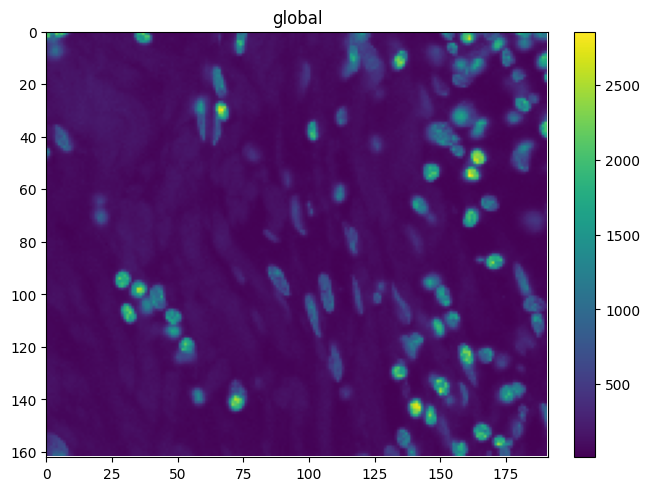

In [35]:
# Plot the cell labels and transcripts
sdata.pl.render_images().pl.show()

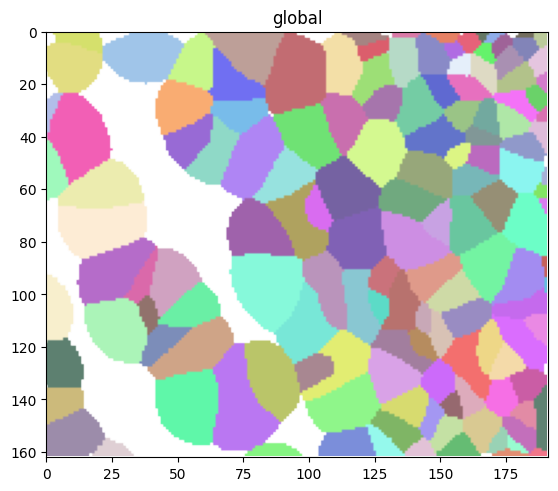

In [153]:
sdata.pl.render_labels().pl.show()

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


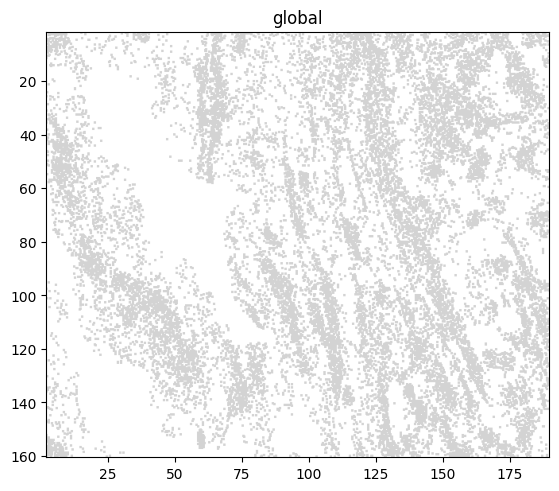

In [65]:
sdata.pl.render_points().pl.show()

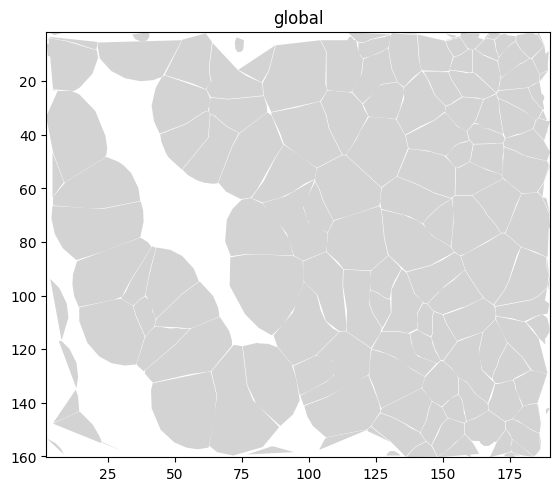

In [154]:
sdata.pl.render_shapes().pl.show()

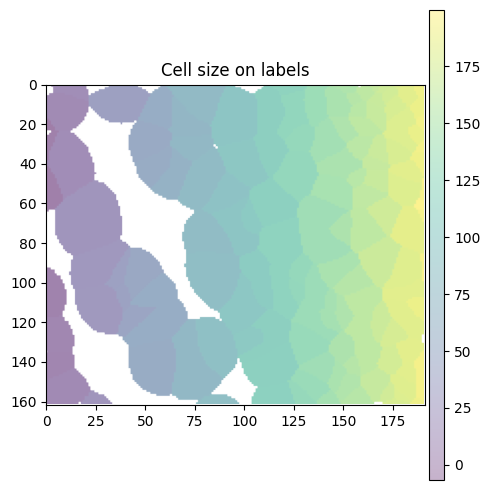

In [103]:
import matplotlib.pyplot as plt
import spatialdata_plot

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

sdata.pl.render_labels(
    color='centroid_x',
    contour_px=1,
    fill_alpha=0.3,
).pl.show(ax=axes)

axes.set_title('Cell size on labels')

plt.tight_layout()

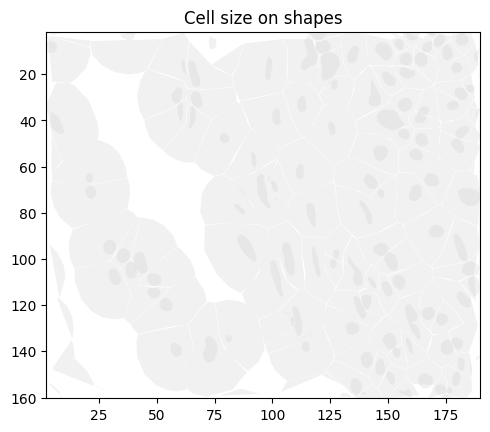

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

sdata.pl.render_shapes(
    #color='centroid_x',
    contour_px=1,
    fill_alpha=0.3,
).pl.show(ax=axes)

axes.set_title('Cell size on shapes')

plt.tight_layout()

In [ ]:
sdata['transcripts'].compute()['feature_name']


,transcript_id,cell_id,overlaps_nucleus,feature_name,x,y,z,qv
0,281612415671617,56816,0,CXCR4,5.595581,3.328369,20.599880,40.000000
1,281612415671622,56816,1,CXCR4,5.760498,1.715332,18.040897,28.161808
2,281612415671676,56123,0,SEC11C,8.567139,7.230713,17.449133,40.000000
3,281612415672231,56814,0,CXCR4,35.716310,4.849121,20.447187,20.682867
4,281612415672914,56813,0,RUNX1,66.451050,4.052734,19.898792,40.000000
...,...,...,...,...,...,...,...,...
22784,281668251115347,80760,0,LUM,188.795170,119.949950,19.145763,40.000000
22785,281668251115351,80479,0,LUM,188.412960,29.869385,16.118443,40.000000
22786,281668251115353,80757,0,LUM,189.224120,135.032470,19.086885,40.000000
22787,281668251115359,80762,0,LUM,188.890260,69.266846,17.280727,40.000000


In [87]:
feature_series = sdata['transcripts'].compute()['feature_name']
contains_epcam = feature_series.isin(['EPCAM']).any()
print("EPCAM found?" , contains_epcam)

EPCAM found? True


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


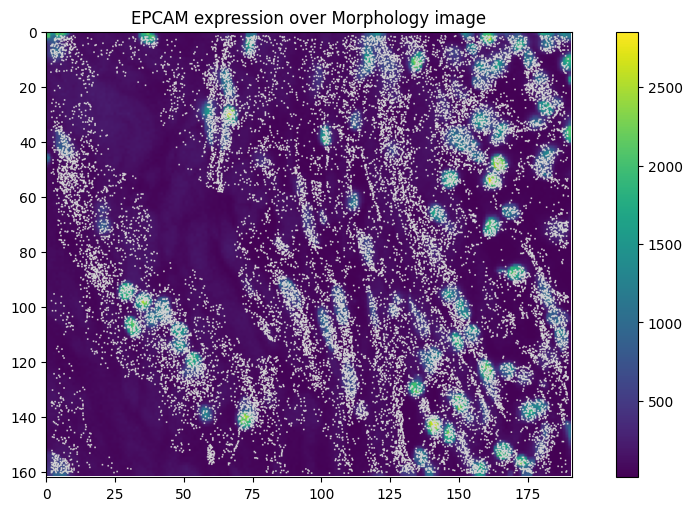

In [105]:
gene_name = 'EPCAM'

sdata.pl.render_images("morphology_focus").pl.render_points(
    "transcripts",
    color=gene_name,
).pl.show(title=f"{gene_name} expression over Morphology image", coordinate_systems="global", figsize=(10, 5))

KeyError: None

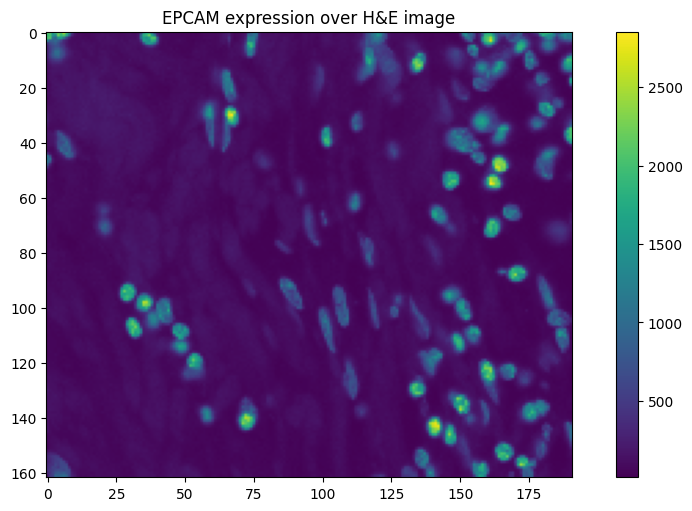

In [116]:
sdata.pl.render_images("morphology_focus").pl.render_shapes(
    color=gene_name,
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups=gene_name,
    palette="orange",
).pl.show(title=f"{gene_name} expression over H&E image", coordinate_systems="global", figsize=(10, 5))

In [40]:
sdata.shapes['cell_boundaries']

,geometry,cell_id,region,instance_id
0,"POLYGON ((123.401 120.144, 122.551 126.731, 12...",4613,cell_labels,4613
1,"POLYGON ((149.113 124.394, 143.588 130.131, 14...",4614,cell_labels,4614
2,"POLYGON ((141.888 134.594, 127.226 142.031, 12...",4615,cell_labels,4615
3,"POLYGON ((145.926 139.694, 145.076 141.606, 14...",4616,cell_labels,4616
4,"POLYGON ((151.876 145.856, 149.538 148.194, 14...",4617,cell_labels,4617
...,...,...,...,...
142,"POLYGON ((185.451 140.119, 186.513 147.769, 18...",80764,cell_labels,80764
143,"POLYGON ((187.151 63.406, 189.913 69.781, 188....",80765,cell_labels,80765
144,"POLYGON ((188.851 85.719, 188.851 88.906, 189....",80766,cell_labels,80766
145,"POLYGON ((189.701 93.369, 189.063 95.919, 189....",80767,cell_labels,80767


In [41]:
sdata.shapes['nucleus_boundaries']

,geometry,cell_id,region,instance_id
0,"POLYGON ((133.813 127.369, 132.963 127.581, 13...",4613,cell_labels,4613
1,"POLYGON ((150.176 132.044, 148.476 133.106, 14...",4614,cell_labels,4614
2,"POLYGON ((140.401 140.119, 139.763 140.331, 13...",4615,cell_labels,4615
3,"POLYGON ((146.776 142.881, 145.076 144.581, 14...",4616,cell_labels,4616
4,"POLYGON ((149.963 148.619, 149.326 149.469, 14...",4617,cell_labels,4617
...,...,...,...,...
122,"POLYGON ((180.563 113.981, 180.563 114.831, 18...",80760,cell_labels,80760
123,"POLYGON ((186.513 107.394, 185.238 108.244, 18...",80761,cell_labels,80761
124,"POLYGON ((182.901 69.356, 181.838 69.569, 180....",80762,cell_labels,80762
125,"POLYGON ((184.388 101.231, 182.476 102.931, 18...",80763,cell_labels,80763
